In [78]:
from apps.onedimensional.linearsystem import linear_system
from apps.onedimensional.linearsystem.riemannexample import riemann_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

from IPython.display import HTML
import numpy as np

# Riemann System Advection Example

0.1352584869408007


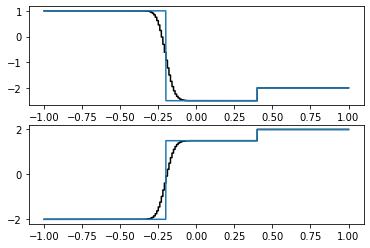

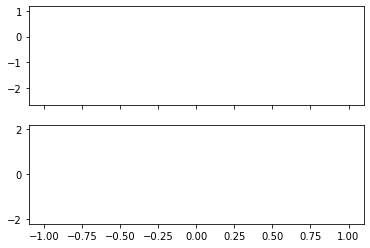

In [53]:
matrix = np.array([[2, 1], [1, 2]])
left_states = [1.0, -2.0]
right_states = [-2.0, 2.0]
discontinuity_locations = [-0.5, -0.5]
time_final = 0.3
problem = riemann_example.RiemannExample(matrix, left_states, right_states, discontinuity_locations)
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 1
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 200
x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "exact_linear"

cfl = dg_utils.standard_cfls(space_time_order)
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))

final_solution = main.run(problem)
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)
error = math_utils.compute_error(final_solution, exact_final_solution)
print(error)

p = plot.create_plot_dg(final_solution, exact_final_solution)
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution)
HTML(ani.to_html5_video())

In [54]:
problem.parameters

{'time_final': 0.3,
 'delta_t': 0.0033333333333333335,
 'is_weak': True,
 'use_wave_propogation_method': False,
 'basis': {'basis_class': 'legendre',
  'num_basis_cpts': 1,
  'inner_product_constant': 0.5},
 'mesh': {'mesh_class': 'mesh_1d_uniform',
  'num_elems': 200,
  'x_left': -1.0,
  'x_right': 1.0},
 'boundary_condition': {'boundary_condition_class': 'extrapolation'},
 'riemann_solver': {'riemann_solver_class': 'exact_linear'},
 'fluctuation_solver': {'fluctuation_solver_class': 'exact_linear'},
 'time_stepping': {'time_stepping_class': 'explicit_runge_kutta',
  'order': 1,
  'num_frames': 10,
  'is_adaptive_time_stepping': False,
  'is_verbose': False}}

# Convergence Test

## DG Convergence

In [45]:
matrix = np.array([[2, 1], [1, 2]])
left_states = [1.0, -2.0]
right_states = [-1.0, 1.5]
discontinuity_locations = [-0.5, -0.5]
problem = riemann_example.RiemannExample(matrix, left_states, right_states, discontinuity_locations)
time_final = 0.3
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "exact_linear"

In [51]:
for num_basis_cpts in range(1,2):
    problem.parameters["basis"]["num_basis_cpts"] = num_basis_cpts
    problem.parameters["time_stepping"]["order"] = num_basis_cpts
    
    cfl = dg_utils.standard_cfls(num_basis_cpts)
    error_list = []
    for num_elems in [200, 400]:
        problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))
        problem.parameters["mesh"]["num_elems"] = num_elems
        final_solution = main.run(problem)
        error = math_utils.compute_error(final_solution, exact_final_solution)
        error_list.append(error)
    order = utils.convergence_order(error_list)
    print(order)
    print(error_list)
    if error_list[-1] >= math_utils.MACHINE_ERROR:
        assert order >= num_basis_cpts

0.0
[0.13900322925703468, 0.11708849734558775]


AssertionError: 

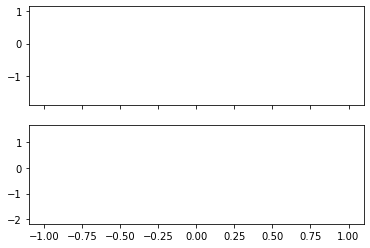

In [52]:
ani, fig = plot.create_animation_output_dir(problem.output_dir)
HTML(ani.to_html5_video())

## FV Convergence

In [67]:
matrix = np.array([[2, 1], [1, 2]])
left_states = [1.0, -2.0]
right_states = [-1.0, 1.5]
discontinuity_locations = [-0.5, -0.5]
problem = riemann_example.RiemannExample(matrix, left_states, right_states, discontinuity_locations)
time_final = 0.3
exact_final_solution = x_functions.FrozenT(problem.exact_solution, time_final)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True
problem.parameters["use_wave_propogation_method"] = True

problem.parameters["basis"]["basis_class"] = "finite_volume"

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["order"] = 1
problem.parameters["time_stepping"]["is_verbose"] = False

x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right

problem.parameters["boundary_condition"]["boundary_condition_class"] = "extrapolation"
problem.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "exact_linear"

In [68]:
cfl = dg_utils.standard_cfls(1)
error_list = []
for num_elems in [200, 400]:
    problem.parameters["delta_t"] = dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems)
    problem.parameters["mesh"]["num_elems"] = num_elems
    final_solution = main.run(problem)
    error = math_utils.compute_error(final_solution, exact_final_solution)
    error_list.append(error)
order = utils.convergence_order(error_list)
print(order)
print(error_list)
if error_list[-1] >= math_utils.MACHINE_ERROR:
    assert order >= 1
else:
    print(error_list)

0.0
[0.13900322925703462, 0.11708849734558771]


AssertionError: 

In [79]:
ani, fig = plot.create_animation_output_dir(problem.output_dir, problem.exact_solution);
HTML(ani.to_html5_video())

<IPython.core.display.Javascript object>